The 1D Heat Equation
$$u_t = \alpha^2 u_{xx}$$

Consider a rod of length L with the following domain: -50 <= x <= 50

Now give it the initial conditions:  
u(x, 0) = 100 for -10 <= x <= 10
u(x, 0) = 0 everywhere else  


Finally, let's finish defining our system by setting boundary conditions: u(-L, t) = u(L, t) = 0  

Now that we've defined our PDE and our system, let's visualize our initial conditions.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [39]:
# Define our domain in python and our spatial step
L = 2 * 50
n = 100
dx = L / n
x = np.linspace(-50, 50, num=n)

# Define how long we want to run our simulation
t_span = [0, 10]  # run simulation for 10 seconds
dt = 0.01  # Set time step size 
snaps = (t_span[1] - t_span[0])/dt  # number of snapshots we will take
t = np.linspace(t_span[0], t_span[1], num=int(snaps))

# Define our thermal diffusivity
alpha = 1

# Define our data matrix for the simulation
u = np.zeros((n, int(snaps)))


In [40]:
# Set you initial conditions in your snapshot matrix
u[np.where((x>=-10) & (x<=10)), 0] = 100

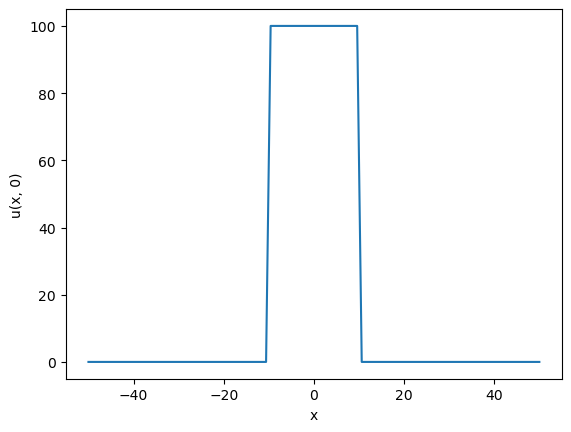

In [41]:
# Visualize our initial state
plt.figure()
plt.plot(x, u[:, 0])
plt.ylabel('u(x, 0)')
plt.xlabel('x')
plt.show()

Now, let's solve our PDE using Fourier Transforms to get our "Ground Truth"

We first need to apply the Fourier Transform to our PDE. We will make use of the property of Fourier Transforms to convert derivatives:
$$\hat{u_t} =  -\alpha^2 \omega^2 \hat{u}$$  

Notice that in the spectral domain, our PDE has become an ODE and is now much easier to solve. 

In [42]:
# Define wave numbers
kappa = 2*np.pi*np.fft.fftfreq(n, d=dx)

# Define our ODE 
F = lambda t, uhat, kappa, alpha: -1 * (alpha**2) * (kappa**2) * uhat

# Solve our ODE with Runge-Kutta scipy solver
u_solved = solve_ivp(F, t_span=t_span, y0=np.fft.fft(u[:, 0]), t_eval=t, args=(kappa, alpha))

# Transform our solution out of the Fourier Domain
for i in range(len(t)):
    u_solved.y[:, i] = np.fft.ifft(u_solved.y[:, i].real)


c:\Users\jacob\anaconda3\envs\pymc_env\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


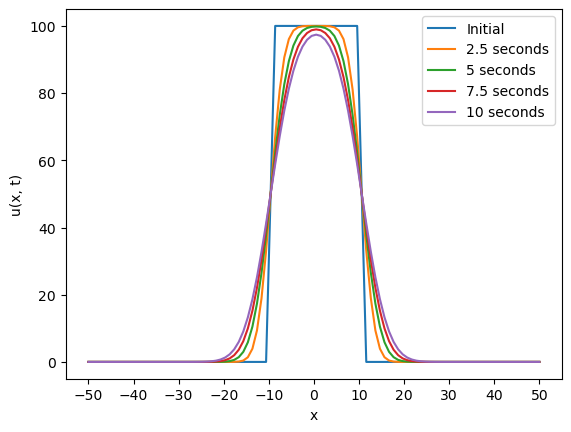

In [43]:
plt.figure(1)
plt.plot(x, u_solved.y[:, 0].real, label='Initial')  # Initial Condition
plt.plot(x, u_solved.y[:, 250], label='2.5 seconds')  #  2.5 seconds
plt.plot(x, u_solved.y[:, 500], label='5 seconds')  # 5 seconds
plt.plot(x, u_solved.y[:, 750], label='7.5 seconds')  # 7.5 seconds
plt.plot(x, u_solved.y[:, 999], label='10 seconds')  # 10 seconds
plt.legend()
plt.ylabel('u(x, t)')
plt.xlabel('x')
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50])
plt.show()

The above figures will act as our "Ground Truth" for our assessing our POD modes and reduced order model.

Let's perform our Singular Value Decomposition or our solution data and start analyzing it.

In [44]:
# Perform SVD using numpy package
U, S, VT = np.linalg.svd(u_solved.y.real)

Let's take a look at how our singular values, which are like measures of importance for each mode, change. 

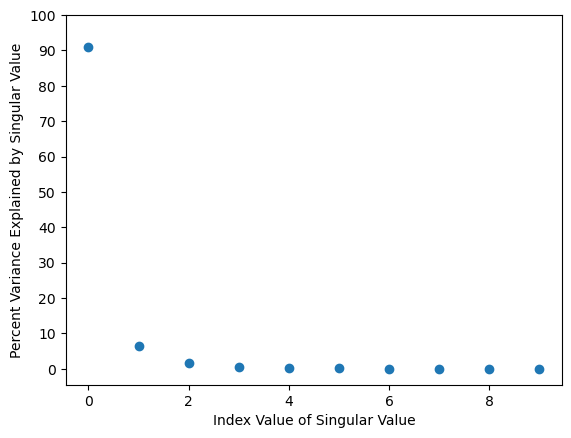

In [46]:
explained_var = S/np.sum(S) * 100

# Plot first 100 singular values
plt.figure()
plt.scatter(range(0, 10), explained_var[0:10])
plt.yscale('linear')
plt.yticks([x for x in range(0, 110, 10)])
plt.xlabel('Index Value of Singular Value')
plt.ylabel('Percent Variance Explained')
plt.show()

We can see that in just the first two singular values, we capture **~97%** of the variance in our solution data! This tells us that we really don't need more than two modes to almost perfectly capture our PDE dynamics.

In [47]:
print(U.shape)
print(S.shape)
print(VT.shape)
test = np.dot(U[:, 0:2] * S[0:2], VT[0:2, :])

(100, 100)
(100,)
(1000, 1000)


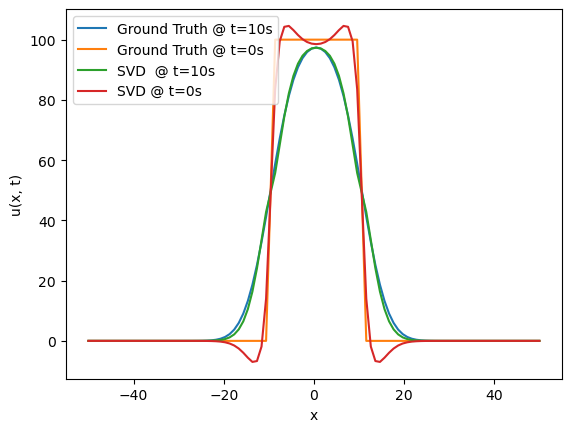

In [48]:
import matplotlib.cm as cm

plt.figure()
plt.plot(x, u_solved.y.real[:, -1], label='Ground Truth @ t=10s')
plt.plot(x, u_solved.y.real[:, 0], label='Ground Truth @ t=0s')
plt.plot(x, test[:, -1], label='SVD  @ t=10s')
plt.plot(x, test[:, 0], label='SVD @ t=0s')
plt.legend()
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.show()


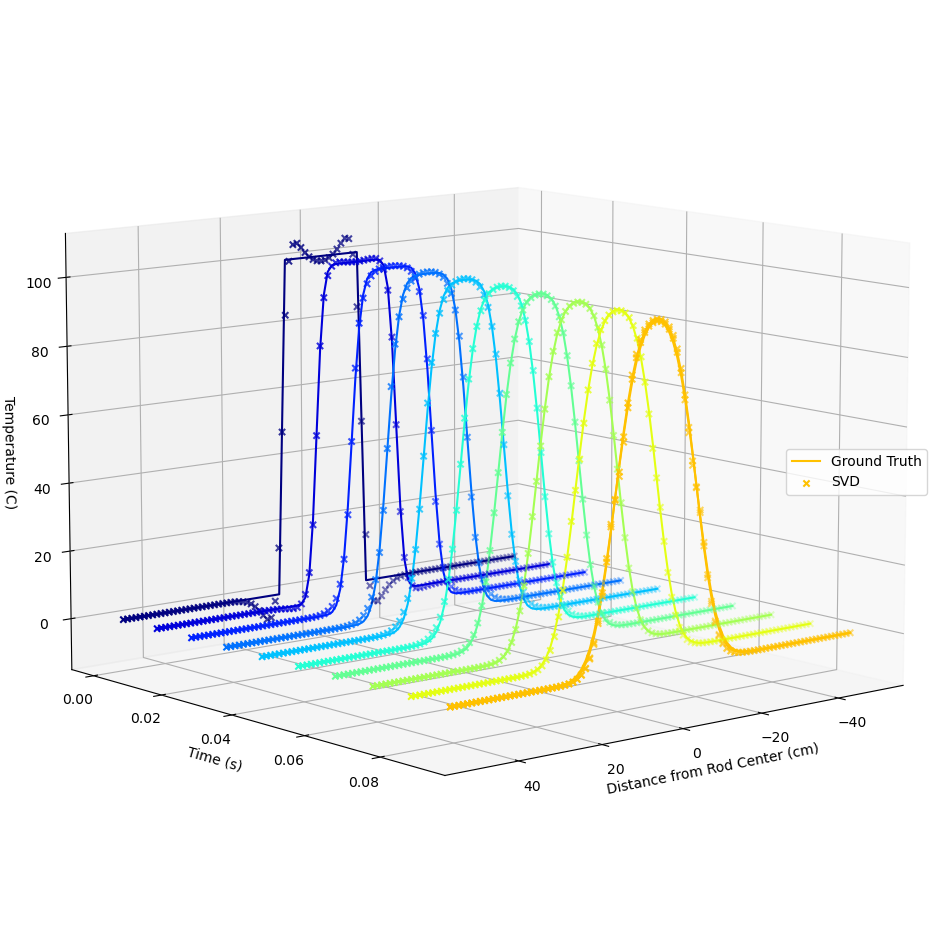

In [68]:
import matplotlib.patches as patches

u_soln = u_solved.y.real
fig = plt.figure(0, figsize=(12, 12), constrained_layout=False)
ax = fig.add_subplot(111, projection='3d')
plt.set_cmap('jet_r')
for k in range(u_soln[:, ::100].shape[1]):
    ys = k*np.ones(u_soln[:, ::100].shape[0])/100
    ax.plot(x, ys, u_soln[:, k*100], color=cm.jet(k*20))
    ax.scatter(x, ys, test[:, k*100], color=cm.jet(k*20), marker='x')
    if k == 9:
        ax.plot(x, ys, u_soln[:, -1], color=cm.jet(k*20), label='Ground Truth')
        ax.scatter(x, ys, test[:, -1], color=cm.jet(k*20), marker='x', label='SVD')



ax.set_xlabel('Distance from Rod Center (cm)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Temperature (C)')
ax.view_init(10, 50)
plt.legend(loc='center right')
plt.show()